# Find 3 Disks
Given an image with a background texture, and three overlaid texured disks, predict the centerpoint of the labeled “most concpicuous disk.”

In [1]:
import gc
import PIL
import math
import time
import random
import numpy as np
from os import listdir
from os.path import join

import os.path

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

df.set_global_random_seed(20220108)
model_save_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

TensorFlow version: 2.7.0


# Define uniform texture dataset

In [2]:
# def MakeUniformTextureDataset(dataset_size, image_size, image_depth):
def make_uniform_dataset(dataset_size, image_size, image_depth):
    dataset_shape = (dataset_size, image_size, image_size, image_depth)
    images = []
    labels = []
    for i in tqdm(range(dataset_size)):
        # (image, label) = generateUniformExample(image_size, image_depth)
        (image, label) = generate_uniform_example(image_size, image_depth)
        images.append(image)
        labels.append(label)
        # # TODO TEMP -- Draw image for debugging
        # if ((i % 50) == 0) and (i < (50 * 5)): df.draw_image(image)
    return (images, labels)

# blah blah
# return an image (pixel tensor) and a label as (x, y) tensor
# def generateUniformExample(image_size, image_depth):
def generate_uniform_example(image_size, image_depth):
    bg_color = np.random.random_sample(image_depth)
    fg_color = np.random.random_sample(image_depth)
    disk_radius = image_size * df.relative_disk_radius()
    image_shape = (image_size, image_size, image_depth)
    image = np.full(image_shape, bg_color, dtype=np.float32)

    # Find 3 non-overlapping disk positions inside image.
    def random_center():
        s = image_size - (2 * disk_radius)
        return (np.random.random_sample(2) * s) + disk_radius
    centers = [random_center()]
    min_dist = 3 * disk_radius
    while len(centers) < 3:
        c = random_center()
        all_ok = True
        for o in centers:
            if (df.dist2d(c, o) < min_dist):
                all_ok = False
        if (all_ok):
            centers.append(c)

    # Draw soft-eged disk with given centerpoint and color.
    def draw_disk(center, color):
        cx = int(center[0])
        cy = int(center[1])
        dr = int(disk_radius)
        for x in range(cx - dr, cx + dr + 1):
            for y in range(cy - dr, cy + dr + 1):
                d = math.sqrt(math.pow(x - cx, 2) + math.pow(y - cy, 2))
                if (d <= dr):
                    blend = df.spot_utility((x, y), center, dr * 0.85, dr)
                    image[x, y, :] = df.interpolate(blend, bg_color, color) 

    # Draw 3 soft-edged disks, with colors progressively more like background.
    draw_disk(centers[0], fg_color)
    draw_disk(centers[1], df.interpolate(0.33, fg_color, bg_color))
    draw_disk(centers[2], df.interpolate(0.66, fg_color, bg_color))

    # return image
    # print('centers[0] =', centers[0])
    # print('type(centers[0]) =', type(centers[0]))
    label = centers[0] / image_size

    # TODO When I visualized the labels, they appeared xy flipped
    #      trying "unflipping them"
    label = np.array((label[1], label[0]))

    return (image, label)

# Reader for complex dataset

In [3]:
# Define complex texture (photo plus synthetic) dataset

# 20220130 this structure (copied from above) is wrong.
# We want to read the dir in the main function.
# the "per filename" function could later be expanded to do amplification
# if so, should return lists, which would need to be concatenated in caller.

# # temp for prototyping
# directory_pathname = '/content/drive/My Drive/PredatorEye/f3d_training_set/'

# # "Amplify" dataset by adding one modified version of each precomputed image
# amplify_2x = True

# def make_complex_dataset():
def make_complex_dataset(directory_pathname =
                         '/content/drive/My Drive/PredatorEye/f3d_training_set/',
                         amplify_2x = True):

    directory_contents = listdir(directory_pathname)

    ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
    # size_limit = 500
    # print('Limit complex dataset size to', size_limit)
    # directory_contents = directory_contents[0:size_limit]
    ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

    images = []
    labels = []
    for filename in tqdm(directory_contents):
        image_pathname = os.path.join(directory_pathname, filename)
        (image, label) = make_complex_example(image_pathname)
        images.append(image)
        labels.append(label)
        if amplify_2x:
            (image, label) = modify_complex_example(image, label)
            images.append(image)
            labels.append(label)
    return (images, labels)

# Read image file at given pathname, pre-process for use in training model.
def make_complex_example(image_pathname):
    # Read image file.
    pixels = df.read_image_file_as_pixel_tensor(image_pathname)
    # Parse disk center position from file name.
    filename = os.path.basename(image_pathname)
    center_position = df.fcd_normalized_xy(filename, pixels)
    return (pixels, center_position)

# Make modified copy of one traing example (as a pixel tensor and xy label).
# (Specifically: invert brighness, mirror horizontally, rotate 1/4, 1/2, or 3/4)
def modify_complex_example(image, label):

    def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
    def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])

    # invert brighness of image:
    image = 1 - image

    # mirror horizontally
    scaled_pixels = np.flip(image, axis=1)
    label = center_flip(label)

    # Rotate one of: 1/4, 1/2, or 3/4
    n = random.randrange(1, 4)
    for i in range(n):
        # image = np.rot90(image, k=1, axes=(0, 1))
        image = np.rot90(image, k=1, axes=(1, 0))
        label = center_rot90(label)
    # label = np.array(label)

    # counter-sensible experiment -- 11:38 20220202
    label = center_flip(label)

    image = image.astype(np.float32)
    return (image, label)

# # make_complex_example()
# (i, p) = make_complex_dataset()
# print('len(i) =', len(i))
# print('i[0].dtype =', i[0].dtype)
# print('i[0].shape =', i[0].shape)
# print('type(i) =', type(i))
# print('p[0] =', p[0])

def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])


print('center_flip((0.2, 0.1)) =', center_flip((0.2, 0.1)))
print('center_flip([0.2, 0.1]) =', center_flip([0.2, 0.1]))
print()
print('center_rot90((0.2, 0.1)) =', center_rot90((0.2, 0.1)))
print('center_rot90([0.2, 0.1]) =', center_rot90([0.2, 0.1]))
print()

print('center_rot90((0.8, 0.4)) =', center_rot90((0.8, 0.4)))
print('center_rot90((0.4, 0.2)) =', center_rot90((0.4, 0.2)))
print('center_rot90((0.2, 0.6)) =', center_rot90((0.2, 0.6)))
print('center_rot90((0.6, 0.8)) =', center_rot90((0.6, 0.8)))

np.array((1,2))

center_flip((0.2, 0.1)) = (0.8, 0.1)
center_flip([0.2, 0.1]) = (0.8, 0.1)

center_rot90((0.2, 0.1)) = (0.1, 0.8)
center_rot90([0.2, 0.1]) = (0.1, 0.8)

center_rot90((0.8, 0.4)) = (0.4, 0.19999999999999996)
center_rot90((0.4, 0.2)) = (0.2, 0.6)
center_rot90((0.2, 0.6)) = (0.6, 0.8)
center_rot90((0.6, 0.8)) = (0.8, 0.4)


array([1, 2])

# Generate dataset

In [4]:
df.reset_random_seeds()
start_time = time.time()

# (dataset_images,
#  dataset_labels) = make_uniform_dataset(dataset_size = 5000,
#                                         image_size = 128,
#                                         image_depth = 3) # RGB

(dataset_images, dataset_labels) = make_complex_dataset()

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

Limit complex dataset size to 500


  0%|          | 0/500 [00:00<?, ?it/s]

Elapsed time: 215 seconds (3 minutes).


# Split dataset

In [5]:
print('Total dataset size =', len(dataset_images))

(images_train, images_test,
 labels_train, labels_test) = train_test_split(dataset_images,
                                               dataset_labels,
                                               test_size=0.2)
 
# 20220202 oops, I was keeping these around, think I ought to free them.
dataset_images = []
dataset_labels = []

# Convert from Python lists to np arrays.
images_train = np.array(images_train, dtype=np.float32)
labels_train = np.array(labels_train, dtype=np.float32)
images_test = np.array(images_test, dtype=np.float32)
labels_test = np.array(labels_test, dtype=np.float32)


print('images_train.shape[0] =', images_train.shape[0])
print('labels_train.shape[0] =', labels_train.shape[0])
print('images_test.shape[0] =', images_test.shape[0])
print('labels_test.shape[0] =', labels_test.shape[0])

Total dataset size = 1000
images_train.shape[0] = 800
labels_train.shape[0] = 800
images_test.shape[0] = 200
labels_test.shape[0] = 200


# Visualize some labels

184


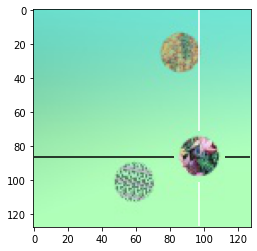

25


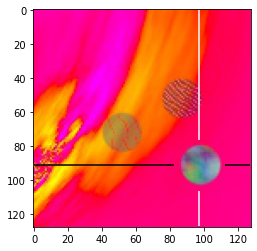

162


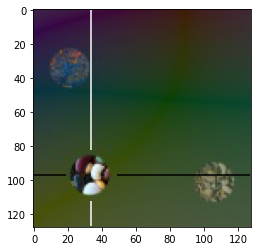

150


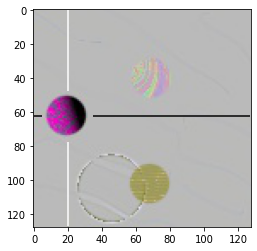

58


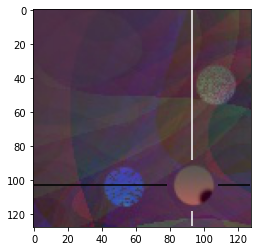

194


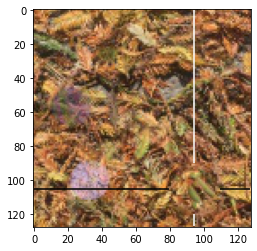

64


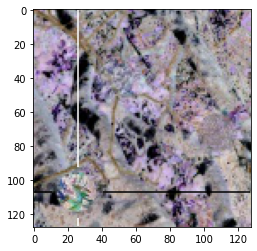

198


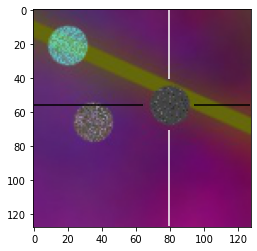

155


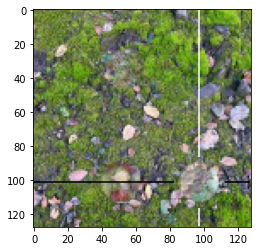

131


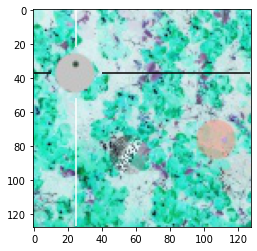

In [6]:
df.reset_random_seeds()
df.visualize_dataset(images = images_test, labels=labels_test)

# Build and train model

Epoch 1/100
7/7 [==============================] - 2s 141ms/step - loss: 5.4966 - accuracy: 0.4775 - in_disk: 0.0063 - val_loss: 0.2223 - val_accuracy: 0.5550 - val_in_disk: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 1s 106ms/step - loss: 0.1317 - accuracy: 0.4900 - in_disk: 0.0400 - val_loss: 0.1525 - val_accuracy: 0.4400 - val_in_disk: 0.0350
Epoch 3/100
7/7 [==============================] - 1s 105ms/step - loss: 0.0880 - accuracy: 0.5188 - in_disk: 0.0425 - val_loss: 0.1881 - val_accuracy: 0.4400 - val_in_disk: 0.0150
Epoch 4/100
7/7 [==============================] - 1s 105ms/step - loss: 0.0779 - accuracy: 0.4963 - in_disk: 0.0463 - val_loss: 0.2077 - val_accuracy: 0.4450 - val_in_disk: 0.0100
Epoch 5/100
7/7 [==============================] - 1s 105ms/step - loss: 0.0688 - accuracy: 0.5125 - in_disk: 0.0587 - val_loss: 0.1790 - val_accuracy: 0.5650 - val_in_disk: 0.0100
Epoch 6/100
7/7 [==============================] - 1s 105ms/step - loss: 0.0640 - accuracy:

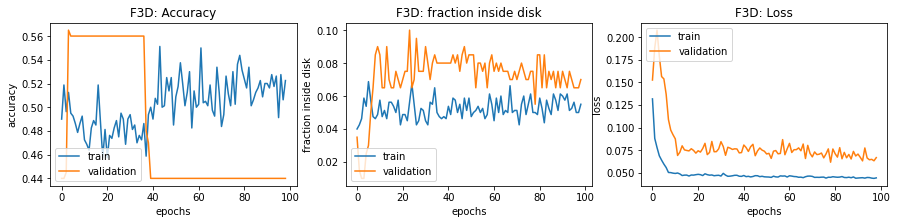

Elapsed time: 75 seconds (1 minutes).
INFO:tensorflow:Assets written to: /content/drive/My Drive/PredatorEye/saved_models/20220204_1717_Find_3_Disks_complex/assets
Saved trained model to /content/drive/My Drive/PredatorEye/saved_models/20220204_1717_Find_3_Disks_complex


In [8]:
# Run a model.
df.reset_random_seeds()
start_time = time.time()
fcd_model_timestamp = df.timestamp_string()
(model, history) = ([], [])  # To release memory when rerunning in notebook.
gc.collect()

model = df.make_disk_finder_model(images_train)
history = df.run_model(model,
                       images_train, labels_train, images_test, labels_test,
                       epochs=100,
                       batch_size= 128,
                       plot_title='F3D')

elapsed_seconds = int(time.time() - start_time)
print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
      str(int(elapsed_seconds / 60)) +' minutes).')

# model.save(model_save_directory + fcd_model_timestamp)
model_save_path = (model_save_directory +
                   fcd_model_timestamp +
                   '_Find_3_Disks_complex')
model.save(model_save_path)
print('Saved trained model to', model_save_path)

In [ ]:
print(type(history))
print(type(history.history['loss']))
print(len(history.history['loss']))
print(history.history['loss'])

# Visualize some predictions

In [ ]:
df.reset_random_seeds()
# df.visualize_dataset(images=images_test, labels=labels_test, model=model)
df.visualize_dataset(images=images_test, labels=labels_test, model=model, count=20)